In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt

# Load data into a pandas DataFrame
df = pd.read_csv("year_2013_2022.csv")
df['Infant'] = df[['< 1 yr',' 1 yr','2 yrs']].sum(axis=1)
df['Children'] = df.loc[:,'3 yrs':'15 yrs'].sum(axis=1)
df['Youth'] = df.loc[:,'16 yrs':'24 yrs'].sum(axis=1)
df['Adult'] = df.loc[:,'25 yrs':'59 yrs'].sum(axis=1)
df['Elderly'] = df.loc[:,'60 yrs':'100 yrs'].sum(axis=1) + df['> 100 yrs']
df.head()

,ปีเดือน,รหัสจังหวัด,ชื่อจังหวัด,รหัสสำนักทะเบียน,ชื่อสำนักทะเบียน,รหัสตำบล,ชื่อตำบล,รหัสหมู่บ้าน,ชื่อหมู่บ้าน,ชาย < 1 ปี,...,96 yrs,97 yrs,98 yrs,99 yrs,100 yrs,Infant,Children,Youth,Adult,Elderly
0,5612,0.0,ทั่วประเทศ,0.0,NaN,0.0,NaN,0.0,NaN,358688,...,9739,7917,6663,4674,4007,2255002,10444999,8615337,33601154,8734101
1,5612,10.0,กรุงเทพมหานคร,0.0,NaN,0.0,NaN,0.0,NaN,24126,...,923,817,645,551,445,154752,822094,715711,3007245,817853
2,5612,11.0,สมุทรปราการ,0.0,NaN,0.0,NaN,0.0,NaN,6976,...,196,150,118,119,75,43225,197426,157035,677341,147885
3,5612,12.0,นนทบุรี,0.0,NaN,0.0,NaN,0.0,NaN,5611,...,280,241,193,166,162,35615,168258,134619,636848,165484
4,5612,13.0,ปทุมธานี,0.0,NaN,0.0,NaN,0.0,NaN,5844,...,106,83,77,53,53,37209,170768,136969,579781,115878


In [39]:
total_pops = df[df['ชื่อจังหวัด']== 'ทั่วประเทศ'][['ชื่อจังหวัด','year','ผลรวมประชากรทั้งหมด','Infant','Children','Youth','Adult','Elderly']].sort_values('year')
total_pops['ผลรวมประชากรทั้งหมด'] = total_pops['ผลรวมประชากรทั้งหมด'].str.replace(',','')
total_pops['ผลรวมประชากรทั้งหมด'] = total_pops['ผลรวมประชากรทั้งหมด'].astype('float')

In [5]:


# Define the independent and dependent variables
X = total_pops[['year']]
y = total_pops['ผลรวมประชากรทั้งหมด']

# Create a polynomial features object with degree 2
model = make_pipeline(PolynomialFeatures(4), Ridge())
# poly = PolynomialFeatures(degree=92)


# Transform the independent variable
# X_poly = poly.fit_transform(X)

# Create a linear regression object
# model = LinearRegression()

# Fit the model to the data
model.fit(X, y)

# Make predictions using the model
y_pred = model.predict(X)

# Calculate the mean squared error
mse = mean_squared_error(y, y_pred)

print("Mean Squared Error: ", mse)


Mean Squared Error:  9345587717.206543


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.122632e-23
  overwrite_a=True).T


In [6]:
degrees = []

for i in range(1,5):
    degrees.append(i)
mse = []

# Loop through the degrees
for degree in degrees:
    # Create a pipeline with a polynomial feature transformer and a Ridge regressor
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    # Fit the model to the data
    model.fit(X, y)
    # Predict using the model
    y_pred = model.predict(X)
    # Calculate the mean squared error
    mse.append(mean_squared_error(y, y_pred))

# Find the degree with the lowest mean squared error
best_degree = degrees[np.argmin(mse)]

print("The best degree for polynomial regression is:",best_degree)


The best degree for polynomial regression is: 3


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.126511e-17
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.122632e-23
  overwrite_a=True).T


In [8]:
from sklearn.linear_model import RidgeCV

alphas = [0.1, 1, 10, 100]

reg = RidgeCV(alphas=alphas)
reg.fit(X, y)
print("The best alpha for Ridge regression is:",reg.alpha_)

The best alpha for Ridge regression is: 10.0


In [9]:
y_pred

array([64735950.62525177, 65239160.71697235, 65652494.72077179,
       65975774.22959137, 66208820.70410919, 66351455.47257233,
       66403499.73088837, 66364774.54261017, 66235100.83882904,
       66014299.41840363])

In [10]:
from sklearn.metrics import r2_score
r2 = r2_score(y, y_pred)
print("R-squared: ", r2)

R-squared:  0.9671272025537443


In [11]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y, y_pred)
print("Mean Absolute Error: ", mae)

Mean Absolute Error:  84139.20642242432


In [62]:
years = []
for i in range(2013,2051):
    years.append(i)
    
ExpoSmoothPred = pd.DataFrame(years, columns = ["year"])
# X_poly_pred = poly.fit_transform(X_pred)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


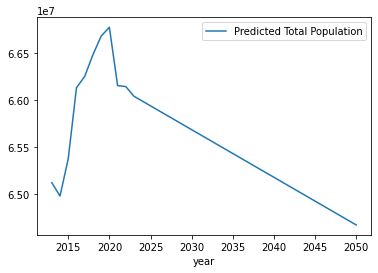

In [63]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split

# total_pops['year'] = pd.to_datetime(total_pops['year'])
# total_pops.set_index('year', inplace=True)

# define the features and target
y = total_pops['ผลรวมประชากรทั้งหมด']


# Set the date column as the index

# Fit the model
model = ExponentialSmoothing(y,trend='add').fit()

# Make predictions
predictions = model.predict(start=0, end=len(total_pops)+27)

ExpoSmoothPred['Predicted Total Population'] = predictions
ExpoSmoothPred.plot.line(x='year',y='Predicted Total Population')
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


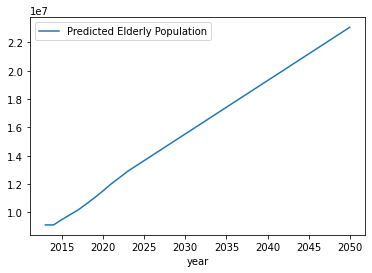

In [64]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split

# total_pops['year'] = pd.to_datetime(total_pops['year'])
# total_pops.set_index('year', inplace=True)

# define the features and target
y = total_pops['Elderly']


# Set the date column as the index

# Fit the model
Emodel = ExponentialSmoothing(y,trend='add').fit()

# Make predictions
Elder_predictions = Emodel.predict(start=0, end=len(total_pops)+27)

ExpoSmoothPred['Predicted Elderly Population'] = Elder_predictions
ExpoSmoothPred.plot.line(x='year',y='Predicted Elderly Population')
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


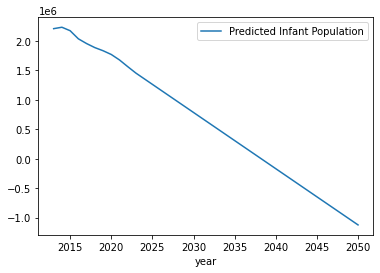

In [65]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split

# total_pops['year'] = pd.to_datetime(total_pops['year'])
# total_pops.set_index('year', inplace=True)

# define the features and target
y = total_pops['Infant']


# Set the date column as the index

# Fit the model
Imodel = ExponentialSmoothing(y,trend='add').fit()

# Make predictions
Infant_predictions = Imodel.predict(start=0, end=len(total_pops)+27)

ExpoSmoothPred['Predicted Infant Population'] = Infant_predictions
ExpoSmoothPred.plot.line(x='year',y='Predicted Infant Population')
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


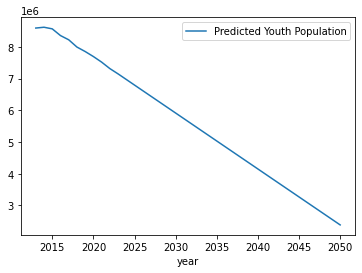

In [66]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split

# total_pops['year'] = pd.to_datetime(total_pops['year'])
# total_pops.set_index('year', inplace=True)

# define the features and target
y = total_pops['Youth']


# Set the date column as the index

# Fit the model
Ymodel = ExponentialSmoothing(y,trend='add').fit()

# Make predictions
Youth_predictions = Ymodel.predict(start=0, end=len(total_pops)+27)

ExpoSmoothPred['Predicted Youth Population'] = Youth_predictions
ExpoSmoothPred.plot.line(x='year',y='Predicted Youth Population')
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


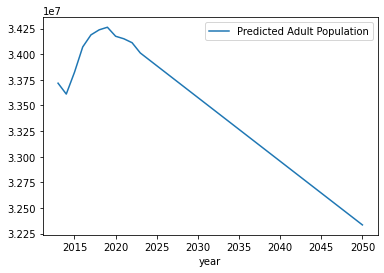

In [67]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split

# total_pops['year'] = pd.to_datetime(total_pops['year'])
# total_pops.set_index('year', inplace=True)

# define the features and target
y = total_pops['Adult']


# Set the date column as the index

# Fit the model
Amodel = ExponentialSmoothing(y,trend='add').fit()

# Make predictions
Adult_predictions = Amodel.predict(start=0, end=len(total_pops)+27)

ExpoSmoothPred['Predicted Adult Population'] = Adult_predictions
ExpoSmoothPred.plot.line(x='year',y='Predicted Adult Population')
plt.show()

In [72]:
ExpoSmoothPred.clip(lower=0, inplace = True)

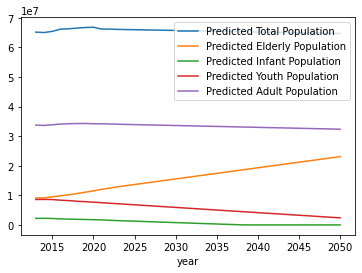

In [73]:
ExpoSmoothPred.plot.line(x='year')

In [74]:
ExpoSmoothPred.to_csv('ExpoSmoothPred.csv',index=False)